## Titanic Survival Prediction Using Machine Learning

## STEP 1: Import the data and look at it

In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [132]:
df = pd.read_csv("//content/train.csv")
dftest = pd.read_csv("//content/test.csv")
df.head()

# the data is compriced of 2 datasets, one for training and one for testing (the "Survived column")

# SibSp: Siblings / Spouses aboard
# Parch: Parents / Children aboard

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## STEP 2: EDA

### For numeric columns

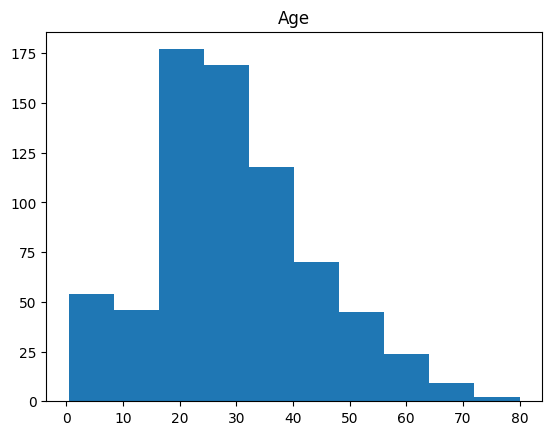

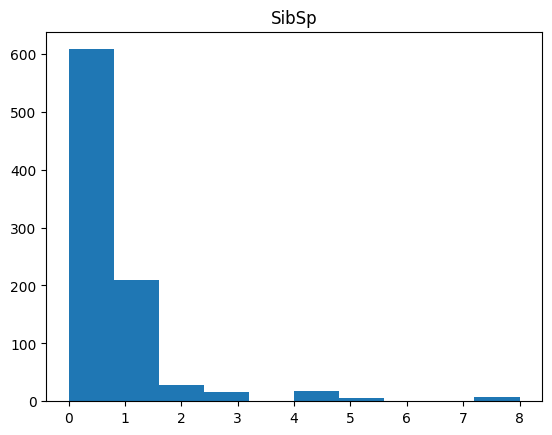

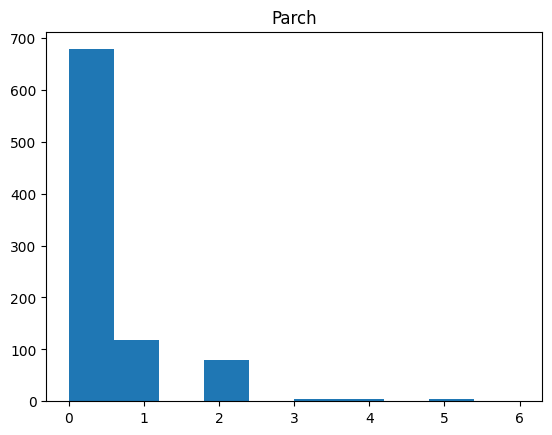

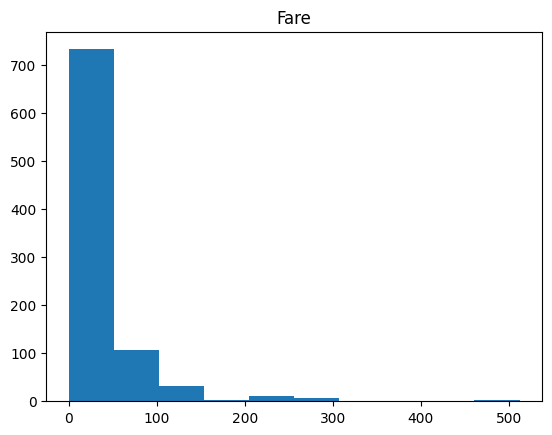

In [133]:
#Plot only relevant (no Pclass) numeric variables in histograms to see more insights about age,
# whether they traveled alone and the fare they paid.

for i in ["Age", "SibSp", "Parch", "Fare"]:
  plt.hist(df[i])
  plt.title(i)
  plt.show()

<Axes: xlabel='Pclass', ylabel='Fare'>

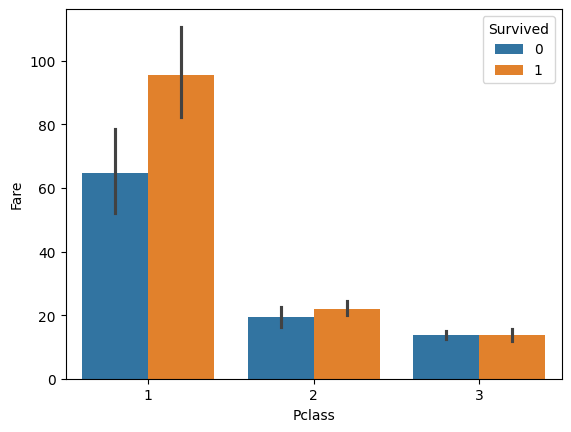

In [134]:
# For each passenger class (1st, 2nd, 3rd), show the average Fare, split by whether the passenger survived or not.
sns.barplot(data=df, x="Pclass", y="Fare", hue="Survived")

# Higher fare maybe better location on the ship. closer to lifeboats, on higher decks, in cabins with faster access to exits.

In [135]:
pd.pivot_table(df, index="Survived", values=["Age", "SibSp", "Parch", "Fare"])

# Survivors were slightly younger on average.
# Survivors paid much higher fares on average.
# Survivors were more likely traveling with parents or children
# Slightly fewer siblings/spouses among survivors (Large families often struggled to escape together).

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


### For categorical colums

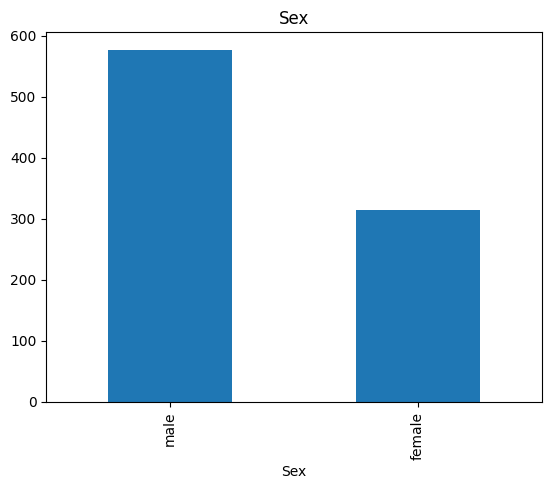

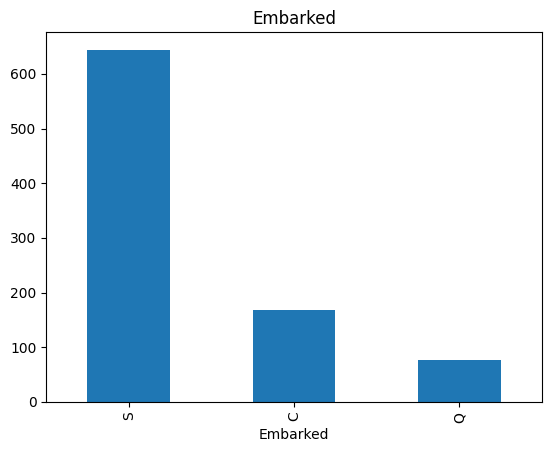

In [136]:
for i in ["Sex", "Embarked"]:
    df[i].value_counts().plot(kind="bar")
    plt.title(i)
    plt.show()

# More males than females
# Southampton was the main departure port.

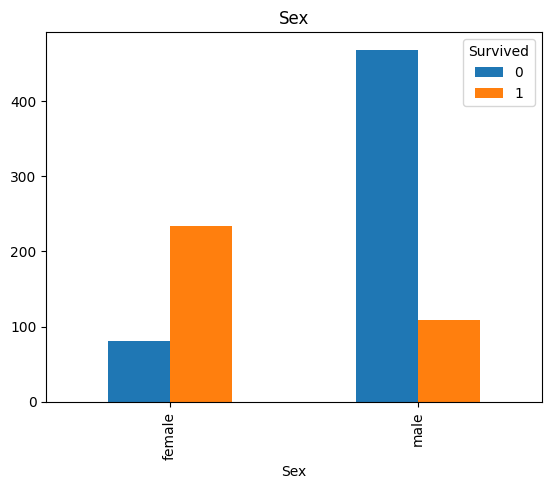

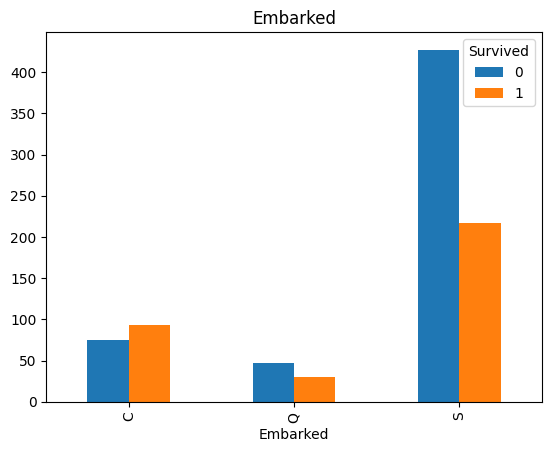

In [137]:
for i in ["Sex", "Embarked"]:
    pd.crosstab(df[i], df["Survived"]).plot(kind="bar")
    plt.title(i)
    plt.show()
# Sex is the single strongest predictor of survival on the Titanic.
# Women and children first. Lots men died


In [138]:
# Group by Survived, split by Sex, and count how many passengers are in each group.
pd.pivot_table(
    df,
    index="Survived",
    columns="Sex",
    values="Ticket", # Ticket is never missing, so counting tickets is counting passengers.
    aggfunc="count")

Sex,female,male
Survived,,
0,81,468
1,233,109


## STEP 3: Clean the data (Preprocessing)

In [139]:
df.info()

# We have some null values and some columns we dont need

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [140]:
# drop PassengerId, Cabin, Name, and Ticket columns (after looking at them and knowing they arent useful)
df = df.drop(["PassengerId", "Cabin", "Name", "Ticket"], axis=1)

# replace AGE NaN for mean
mean = df["Age"].mean()
df["Age"] = df["Age"].fillna(mean)

# change data type on age
df["Age"] = df["Age"].astype(int)

# fill de Nan of Embarked with the mode
mode = df["Embarked"].mode()[0]
df["Embarked"] = df["Embarked"].fillna(mode)
df.info()

# Looking again to the df.info, we see that we have no more null values. the data is cleaned.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    int64  
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(1), int64(5), object(2)
memory usage: 55.8+ KB


## STEP 4: Feature Engineering

### Apply Log-Transformation to Fare

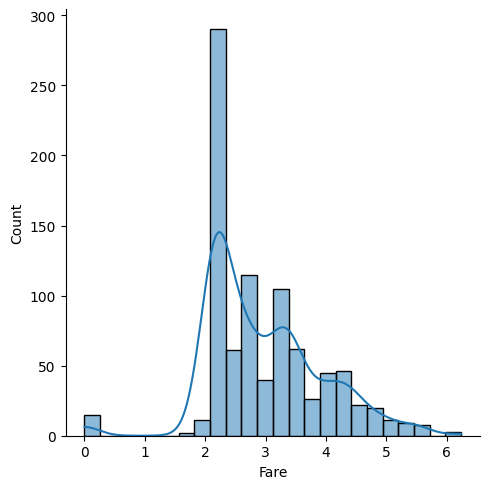

In [141]:
# Apply log to "Fare" as it is extremely right-skewed, and regression works better with more symmetric variables.
df["Fare"] = np.log(df["Fare"]+1)
sns.displot(df["Fare"], kde=True)

# we didnt apply log to SibSp and Parch (even if they are also right-skeweb) because they are small count variables,
# not continuous monetary variables like Fare.
# Log-transforming them would not add much value and could actually hurt interpretability

### Correlation Matrix
- After applying log to Fare, we can now see cleaner linear relationships between variables.
- If fare had stayed raw, Correlation might be misleading and Regression coefficients unstable.
- After log-transforming Fare, a correlation heatmap is used to assess linear relationships between numeric features and survival, and to check for multicollinearity before regression.

<Axes: >

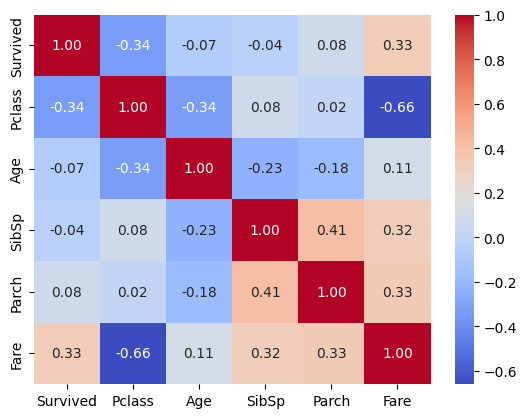

In [142]:
correlation = df.corr(numeric_only=True)
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")

# Survived and Fare: +0.33 = Higher fare indicates higher survival probability
# Survived and Pclass: -0.34 = Higher class number (worse class) indicates lower survival
# Survived and Age: -0.07 = Very weak relationship

### Encode colums "Sex" and "Embarked"
- Models cannot work with strings (last df.info())
- we are converting categorical variables into numbers so that a machine-learning / regression model can use them.

In [143]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in ["Sex", "Embarked"]:
  df[i] = le.fit_transform(df[i])
df.head()

# male = 0
# female = 1

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22,1,0,2.110213,2
1,1,1,0,38,1,0,4.280593,0
2,1,3,0,26,0,0,2.188856,2
3,1,1,0,35,1,0,3.990834,2
4,0,3,1,35,0,0,2.202765,2


## STEP 5: Regression Analysis (In- Sample Performance)
- Now that we have done exploratory data analysis, and cleaned the dataset (replace null values, log to fare and encode categorical columns), we can perform regression analysis

### Determine X and Y

In [144]:
X = df.drop(["Survived"], axis = 1)
y = df["Survived"]

### Evaluation Function
- This function trains a classification model using a train–test split, evaluates its accuracy on unseen test data, and then applies 5-fold cross-validation to obtain a more robust estimate of model performance. The final cross-validation score is reported as the average accuracy across all folds.

In [145]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

def classify(model):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=40)

    # train the model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print("Accuracy:", acc)

    score = cross_val_score(model, X, y, cv=5)
    print("CV SCORE :", np.mean(score)) # we got 5 accuracy measures here, so we average them

### Decision Tree Classifier

In [146]:
from sklearn.tree import DecisionTreeClassifier

Decisiontree_model = DecisionTreeClassifier()
classify(Decisiontree_model)

# A Decision Tree model works like a series of yes/no questions.
#Based on the answers, the passenger goes left or right down the tree until a final decision is made:
# Survived (1) or Did not survive (0)

Accuracy: 0.7988826815642458
CV SCORE : 0.7766869625258929


### LGBM Classifier

In [147]:
from lightgbm import LGBMClassifier


lgbm_model = LGBMClassifier(verbosity=-1) # to get rid of the warnings
classify(lgbm_model)

# Is a tree-based model, but instead of using one single tree, it uses many small decision trees combined together.
# Each new tree focuses on fixing the mistakes made by the previous ones.
# This approach is called gradient boosting.

Accuracy: 0.8547486033519553
CV SCORE : 0.8271922666499278


### XGBoost Classifier

In [148]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier()
classify(xgb_model)

# is an advanced ensemble model that uses gradient boosting with decision trees.
# Like LightGBM, it builds many small trees, where each new tree focuses on correcting the errors of the previous ones.

Accuracy: 0.8379888268156425
CV SCORE : 0.8215805661917017


### Random Forest Classifier

In [149]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
classify(rf_model)

# Is an ensemble model that combines many decision trees and lets them vote on the final prediction.
# Instead of relying on one tree, it builds a forest of trees, each trained on a random sample of the data and features.

Accuracy: 0.7988826815642458
CV SCORE : 0.8159876969430669


### Extra Trees Classifier

In [150]:
from sklearn.ensemble import ExtraTreesClassifier

et_model = ExtraTreesClassifier()
classify(et_model)

# Extremely Randomized Trees is an ensemble model similar to Random Forest, but it adds more randomness when building trees.
# It builds many decision trees and combines their predictions using majority voting.

Accuracy: 0.7988826815642458
CV SCORE : 0.796899127487289


### Logistic Regression

In [151]:
from sklearn.linear_model import LogisticRegression

logit_model = LogisticRegression(max_iter=1000)
classify(logit_model)

# Logistic regression is trained using an iterative optimization process (Each iteration = one attempt to improve the model)
# The default (max_iter=100) is sometimes not enough, with multiple features and scaled / transformed variables.

Accuracy: 0.8156424581005587
CV SCORE : 0.7845144686460359


## STEP 5: Regression Analysis (Out-Of-Sample Performance)
- Here we are going to start using the test dataset (dftest)


### Choose the best model
- After comparing the accuracy and cross validation scores of the different models above, the best model was XGBoost model

In [152]:
# we are done evaluating. so we train in all available data.
# "Now that we trust this model, give it all the data so it learns as much as possible"

best_model = XGBClassifier()
best_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### Preprocessing of the TEST data

In [153]:
# drop PassengerId, Cabin, Name, and Ticket columns (as before)
dft = dftest.drop(["PassengerId", "Cabin", "Name", "Ticket"], axis=1,  errors="ignore")
dft.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [154]:
# replace the null values in Age and Fare with the mean
for i in ["Age", "Fare"]:
  mean = dft[i].mean()
  dft[i] = dft[i].fillna(mean)

# change the data type for Age column
dft["Age"] = dft["Age"].astype(int)

In [155]:
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    int64  
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 23.0+ KB


### Encode categorical variables again

In [156]:
le = LabelEncoder()
for i in ["Sex", "Embarked"]:
  dft[i] = le.fit_transform(dft[i])
dft.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34,0,0,7.8292,1
1,3,0,47,1,0,7.0000,2
2,2,1,62,0,0,9.6875,1
3,3,1,27,0,0,8.6625,2
4,3,0,22,1,1,12.2875,2


### Apply Log-Transformation to Fare column

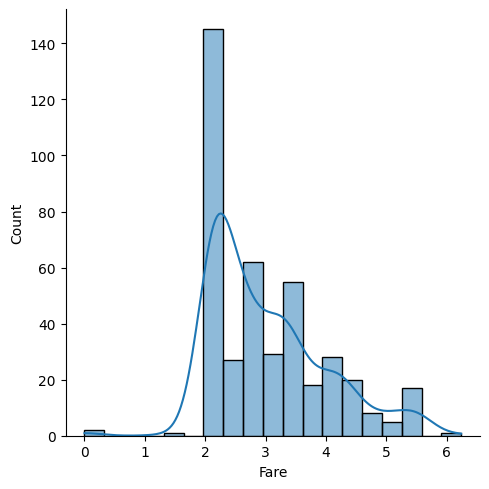

In [157]:
dft["Fare"] = np.log(dft["Fare"]+1)
sns.displot(dft["Fare"], kde=True)

### Fit the XGBoost (Best Model)
- Now that we have performed preprocessing to the new TEST data, we can now fit our best model

In [158]:
final_prediction= best_model.predict(dft)
final_prediction

array([0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [160]:
passenger_ids = dftest["PassengerId"]
submission = pd.DataFrame({
    "PassengerId": passenger_ids,
    "Survived": final_prediction
})
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
